# Optimize hyperparameters for each mutation matrix
We will optimize hyperparameters of the RF model for each mutation matrix. The optimization will be based on the MAE performance of model over four validation seasons from 2012NH to 2013SH.

## Imports

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import utilities   # self defined functions
import model_utilities   # self defined models
from ast import literal_eval
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pickle

# for hyperparameter optimization
from hyperopt import Trials, tpe, hp, fmin, space_eval
from hyperopt.pyll import scope

# (for reproduciblility) fix the randomly generated numbers
SEED = 100
np.random.seed(SEED)

## Objective function for hyperopt
The objective is to minimize the average MAE over validation seasons. This function will train the RF model with provided hyperparameters and return the average MAE.

> **Parameters**
> - params (dict): dictionary of hyperparameters and corresponding values

> **Returns**
> - avg_mae (float): MAE average over validation seasons

In [ ]:
def objective(params):
    actual_all  = []
    predict_all = []
    
    # loop through validation seasons
    for ind_train, ind_valid in indices_folds:
        '''
        Assign training and validation datasets
        '''
        # training dataset
        data_train = data.iloc[ind_train].copy()
        data_train.reset_index(drop=True, inplace=True)

        # validation dataset
        data_valid = data.iloc[ind_valid].copy()
        data_valid.reset_index(drop=True, inplace=True)
        
        
        '''
        Input features (genetic difference)
        '''
        # training dataset
        X_train = pd.DataFrame(data_train.seq_diff.to_list(),
                               index=data_train.index,
                               columns=HA1_features)
        X_train.fillna(0, inplace=True)   # replace nan with 0

        # validation dataset
        X_valid = pd.DataFrame(data_valid.seq_diff.to_list(),
                               index=data_valid.index,
                               columns=HA1_features)
        X_valid.fillna(0, inplace=True)   # replace nan with 0


        '''
        Input features (metadata features)
        '''
        X_train_meta = data_train[meta_features].fillna('None').astype('str')
        X_valid_meta = data_valid[meta_features].fillna('None').astype('str')


        # one hot encoding
        ohe = OneHotEncoder(handle_unknown='ignore')
        X_train_meta = ohe.fit_transform(X_train_meta).toarray()
        X_valid_meta = ohe.transform(X_valid_meta).toarray()

        X_train = np.hstack((X_train.values, X_train_meta))
        X_valid = np.hstack((X_valid.values, X_valid_meta))


        del X_train_meta, X_valid_meta
        
        
        '''
        Training and validation
        '''
        model = RandomForestRegressor(**params, random_state=SEED, n_jobs=-1)
        model.fit(X_train, data_train.nht.values)
        predict_valid = model.predict(X_valid)
        
        '''
        save actuals and predictions
        '''
        actual_all.append(data_valid.nht.values)
        predict_all.append(predict_valid)
        
        ##################
        # End seasons loop
        ##################
    
    actuals     = np.concatenate(actual_all)
    predictions = np.concatenate(predict_all)
    
    
    '''
    metric or loss
    '''
    avg_mae = mean_absolute_error(actuals, predictions)
    
    return avg_mae

## Variables

In [2]:
Valid_Seasons = ['2012NH', '2012SH', '2013NH', '2013SH'] # seasons from 2012NH to 2013SH

HA1_features  = [f"HA1_{x}" for x in range(1,329+1)]
meta_features = [
                 'virus',   # virus avidity
                 'serum',   # antiserum potency
                 'virusPassCat',
                 'serumPassCat'
                 ]   # metadata features

metadata   = 'a+p+vPC+sPC'   # label to record which metadata is being used
model_name = 'RF'   # identifier for the type of model to be used

## Paths and filenames

In [3]:
# paths
path_data   = "../data/"   # path of data
path_result = "../results/SuppFig3_optimization_RFmodel/"   # results will be saved in this directory
Path(path_result+"/hyperopt_trials/").mkdir(parents=True, exist_ok=True)   # make directory if it does not exist already

# filenames
mut_mat_fn  = path_data + "aaIndID_selected.txt"   # filename of list of valid mutation matrics
optimize_fn = path_result+"SuppFig3c_optimize_mut_mat_hyperopt.csv"   # to save optimization results
fig_fn      = path_result+'SuppFig3c_optimize_mut_mat_hyperopt.svg'   # to save figure

## Read valid mutation matrices used for encoding genetic difference

In [ ]:
mut_mat_List = pd.read_csv(mut_mat_fn, header = None)
mut_mat_List = mut_mat_List[0].tolist()

## Indices of training and validation datasets for validation seasons

In [ ]:
# read dataset temporarily
dummy = pd.read_csv(path_data+"nhts_ha1_binary.csv",
                    converters={"seq_diff": literal_eval})

# to collect train and valid indices for each validation season
indices_folds = []

# loop through each validation season
for valid_season in Valid_Seasons:
    '''
    Train Test Split
        - based on seasonal framework
        - Train: past virus isolates paired with past sera
        - Test: circulating virus isolates paired with past sera
    '''
    ind_train, ind_valid = utilities.seasonal_trainTestSplit(dummy.copy(), valid_season)
    
    indices_folds.append((ind_train, ind_valid))

del dummy, ind_train, ind_valid

## Optimization

In [ ]:
'''
loop through mutation matrices
'''
for mut_mat in mut_mat_List:
    
    print("Mutation matrix: ", mut_mat)
    

    '''
    Dataset
    '''
    # Genetic difference (seq_diff) encoded as per the mutation matrix
    # Converter is used to load the genetic difference saved as a list of floats
    data = pd.read_csv(path_data+f"nhts_ha1_{mut_mat}.csv",
                       converters={"seq_diff": literal_eval})
    

    '''
    Hyper-parameter optimization
    '''
    try:
        '''
        load the trials object
        '''
        with open(path_result+f"hyperopt_trials/trials_{mut_mat}.hyperopt", "rb") as f:
            trial     = pickle.load(f)
            max_evals = len(trial) + 5
    except:
        # hyperopt initialize trials object
        trial = Trials()
        max_evals = 50
    
    # hyperparameters search space
    space={'n_estimators': scope.int(hp.quniform('n_estimators', 50, 1000, 25)),
           'max_features': scope.float(hp.uniform('max_features', 0.1, 0.75)),
           'max_depth': scope.int(hp.quniform('max_depth', 50, 200, 10)),
           'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),
           'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 30, 1)),
           'bootstrap': hp.choice('bootstrap', [False, True])}
    
    # hyperopt minimization
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=max_evals, 
                trials=trial,
                rstate=np.random.default_rng(SEED))
    
    
    '''
    Best hyperparameters
    '''
    hyperparams = {'model': model_name,
                   'metadata': metadata,
                   'mut_mat': mut_mat,
                   'mae': trial.best_trial['result']['loss']}
    hyperparams.update(space_eval(space, best))
    print(hyperparams)
    
    utilities.saveDict2CSV([hyperparams], optimize_fn)
    
    
    '''
    save the trials object
    '''
    with open(path_result+f"hyperopt_trials/trials_{mut_mat}.hyperopt", "wb") as f:
        pickle.dump(trial, f)

## Imports and configuration for plotting

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
%matplotlib inline

sns.set_context(rc={"axes.labelsize":9,
                    "xtick.labelsize":8,
                    "ytick.labelsize":8,
                    "legend.fontsize":8,
                    "legend.title_fontsize":8})

## Read optimization results and prepare data for plots

In [5]:
scores = pd.read_csv(optimize_fn)

# sort as per optimized mae
scores.sort_values(by=['mae'], ascending=True, inplace=True)

top5 = f"1. {scores.mut_mat.iloc[0]},   2. {scores.mut_mat.iloc[1]}\n3. {scores.mut_mat.iloc[2]},    4. {scores.mut_mat.iloc[3]}\n5. {scores.mut_mat.iloc[4]}"

## Plot average MAE for optimized hyperparameters for each mutation matrix

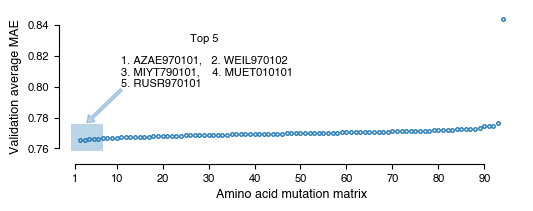

In [6]:
fig, ax = plt.subplots(figsize=(6, 2))

ax.plot(range(1, len(scores)+1), scores.mae.values,
        'o', fillstyle='none', markersize=2.5, color='C0')


# Top 5 substitution matrices
# Rectangle Patch
y0, y1 = ax.get_ylim()
rect_Yend = (y1-y0)/5
rect = Rectangle((-1, y0-0.003), width=7, height=rect_Yend, alpha=0.3, zorder=0.5)
ax.add_patch(rect)

# annotation
ax.annotate('', xy=(2.5, y0+rect_Yend-0.002), xytext=(10, y0+rect_Yend+0.0195),
            arrowprops=dict(facecolor='C0', edgecolor='C0', alpha=0.3,
                            width=2, headwidth=7, headlength=5),
            fontsize=8, zorder=0.1)

ax.text(25, 0.829, "Top 5", fontsize=8, fontweight='bold')
ax.text(10, 0.8, top5, fontsize=8)


# configurations for figure
ax.set_xticks([0, 9, 19, 29, 39, 49, 59, 69, 79, 89])
ax.set_xticklabels([1, 10, 20, 30, 40, 50, 60, 70, 80, 90])
ax.set_ylim(bottom=0.75, top=0.85)
ax.set_xlabel("Amino acid mutation matrix", fontsize=9)
ax.set_ylabel("Validation average MAE", fontsize=9)

sns.despine(trim=True)

# save figure
fig.savefig(fig_fn, format='svg', bbox_inches='tight')